## Final rescale for paper 1

Since all our scaling is based of the squeezing/stretching of isopyncals and isoconcetration lines near the head, I moved the virtual station DnC to be close to the head (UwH for "upwelling near the head"). The sum of the max stratification above 100 m (rim?) and min stratification below 100 m correlates well with the upwelling flux $\Phi$. So , the stratification, and for that matter tracer gradient, that we want to scale is the one at the head and not at DnC (around mid length). In this notebook I rescale N above, N below, dC/dz above and below and C. 

In [1]:
#import gsw as sw # Gibbs seawater package

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
from matplotlib.ticker import FormatStrFormatter
from netCDF4 import Dataset
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import scipy.stats
import warnings
warnings.filterwarnings("ignore")
import xarray as xr

import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [2]:
sns.set_context('talk')
sns.set_style('white')

In [3]:
CanyonGrid='/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

CanyonGridNoC='/data/kramosmu/results/TracerExperiments/CNTDIFF/run68/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonState='/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

# Grid variables
nx = 616
ny = 360
nz = 90
nt = 19 # t dimension size 
time = CanyonStateOut.variables['T']

In [4]:
# Constants and scales

L = 6400.0 # canyon length
R = 5000.0 # Upstream radius of curvature
g = 9.81 # accel. gravity
Wsb = 13000 # Width at shelf break
Hs = 147.5 # Shelf break depth
s = 0.005 # shelf slope 
W = 8300 # mid-length width
Hh= 97.5 # head depth
Hr = 132.0 # rim depth at DnS
# NOTE: The default values of all functions correspond to the base case

def Dh(f=9.66E-4,L=6400.0,N=5.5E-3):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U=0.37,f=9.66E-4,R=5000.0):
    '''Rossby number using radius of curvature as length scale'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N=5.5E-3,f=9.66E-5,W=8300,Hs=150.0):
    '''Burger number'''
    return(N*Hs/(f*W))

def RossbyRad(N=5.5E-3,Hs=150.0,f=9.66E-4):
    '''1st Rossby radius of deformation'''
    return(N*Hs/f)

In [5]:
# Information for all runs is stored in canyon_records.py
lib_path = os.path.abspath('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/PythonScripts/Paper1Figures/') # Add absolute path to my python scripts
sys.path.append(lib_path)

import canyon_records 

records = canyon_records.main()

### Not all runs are used to fit all variables

**records_dyn** has all runs where f, N or U vary. USe this list to fit upwelling flux $\Phi$ and modify *Howatt and Allen 2013*.

**records_step** has all runs in records_dyn plus the runs with a step Kv profile. Use this list to fit $\Phi$ with scaled N.

**records_kv** has all runs with step Kv profile. Use this list to fit N below for step Kv runs.

**records_nokv** has all runs except the ones with step Kv profile. Use this list to fit N below.

In [12]:
# Indices of all runs that will be considered for paper 1

select_rec = [0,1,2,3,4,5,6,7,8,9,10,17,18,19,20,21,
              22,23,24,25,26,27,28,29,30,31,32,33,
              34,35,38,39,41,42,43,44,45,46,47,48,49]
for ii in select_rec:
    print(ii,records[ii].name)

0 CNTDIFF_run38
1 CNTDIFF_run37
2 CNTDIFF_run36
3 CNTDIFF_run45
4 CNTDIFF_run73
5 CNTDIFF_run75
6 CNTDIFF_run79
7 CNTDIFF_run67
8 CNTDIFF_run51
9 CNTDIFF_run69
10 CNTDIFF_run71
17 LOWER_BF_run01
18 LOW_BF_run01
19 LOWEST_BF_run01
20 LOWEST_BF_run03
21 LOWEST_BF_run05
22 LOWEST_BF_run07
23 LOWEST_BF_run11
24 3DVISC_REALISTIC_run01
25 3DVISC_REALISTIC_run02
26 3DVISC_REALISTIC_run03
27 3DVISC_REALISTIC_run05
28 3DVISC_REALISTIC_run06
29 3DVISC_REALISTIC_run07
30 3DVISC_REALISTIC_run08
31 3DVISC_REALISTIC_run09
32 3DVISC_REALISTIC_run10
33 3DVISC_REALISTIC_run11
34 3DVISC_REALISTIC_run12
35 3DVISC_REALISTIC_run13
38 3DVISC_REALISTIC_run16
39 3DVISC_REALISTIC_run17
41 3DVISC_REALISTIC_run19
42 3DVISC_REALISTIC_run20
43 3DVISC_REALISTIC_run21
44 3DVISC_REALISTIC_run22
45 3DVISC_REALISTIC_run23
46 3DVISC_REALISTIC_run24
47 3DVISC_REALISTIC_run25
48 3DVISC_REALISTIC_run26
49 3DVISC_REALISTIC_run27


In [18]:
# records_dyn has all the runs without the ones where K_bg changes. Use these ones for fitting the data HA2013
ind = [0,3,4,5,6,7,8,9,10,17,18,19,20,21,22]
records_dyn = []
for ii in ind:
    records_dyn.append(records[ii])

# records_step has all the runs in records_dyn plus the step runs (use these to fit Phi with Nmean)
ind = [0,3,4,5,6,7,8,9,10,17,18,19,20,21,22,38,39,45,46,47,48,49]
records_step = []
for ii in ind:
    records_step.append(records[ii])

# records_epsilon has all the runs in records_step plus the epsilon runs (use these to fit Nmax+Nmin)
ind = [0,3,4,5,6,7,8,9,10,17,18,19,20,21,22,29,30,31,32,33,
       34,35,38,39,41,42,43,44,45,46,47,48,49]
records_epsilon = []
for ii in ind:
    records_epsilon.append(records[ii])

# records_real has all the runs in records_epsilon plus the realistic runs
ind = [0,3,4,5,6,7,8,9,10,17,18,19,20,21,22,24,25,26,27,28,29,30,31,32,33,
       34,35,38,39,41,42,43,44,45,46,47,48,49]
records_real = []
for ii in ind:
    records_real.append(records[ii])

# records_diffusivity has all the runs with step and epsilon kv profiles; it does not have the dynamics runs
ind = [29,30,31,32,33,34,35,38,39,41,42,43,44,45,46,47,48,49]
records_diffusivity = []
for ii in ind:
    records_diffusivity.append(records[ii])

    
# records_kv has the runs with step kv profile
ind = [28,32,37,38,44,45,46,47,48] 

records_kv = []
for ii in ind:
    records_kv.append(records[ii])

# records_nokv has the runs without step kv profile
ind = [0,3,4,5,6,7,8,9,10,17,18,19,20,21,22,29,30,31,32,33,34,35,41,42,43,44]
       
records_nokv = []
for ii in ind:
    records_nokv.append(records[ii])

# records3 has all the runs without the ones where K_bg changes and run with low U high N.
ind = [0,3,4,5,6,7,8,9,10,17,18,19,21,22]
records3 = []
for ii in ind:
    records3.append(records[ii])



In [19]:
records_sel = []

for ind in select_rec:
    records_sel.append(records[ind])
    file = ('/data/kramosmu/results/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(records[ind].exp_code,
                                                                                records[ind].exp_code,
                                                                                records[ind].run_num))
    dfcan = pd.read_csv(file)
    records[ind].HCW = dfcan['HCW']
    records[ind].HCWTr1 = dfcan['HCWTr1']
    records[ind].TrMass = dfcan['TrMassHCW']
    records[ind].TrMassTr1 = dfcan['TrMassHCWTr1']
    records[ind].TrMassTr2 = dfcan['TrMassHCWTr2']
    records[ind].TrMassTot = dfcan['TotTrMass']
    records[ind].TrMassTotTr2 = dfcan['TotTrMassTr2']
    records[ind].TrMassTotTr1 = dfcan['TotTrMassTr1']
   

In [20]:
keys2 = ['N_tt16','N_tt18']
stname = 'UwH' # Station at downstream head side of canyon

for ind in select_rec:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/N_%s_%s.csv' %
                 (records[ind].name,stname))
    df = pd.read_csv(filename1)
    Nab = 0
    Nbe = 0
    Nrim = 0 
    Nmean = 0
          
    for key,ii in zip(keys2, range(len(keys2))):
        Nab = Nab + np.max(df[keys2[ii]][:20]) #0:20
        Nbe = Nbe + np.min(df[keys2[ii]][20:25]) #20:24
        
    records[ind].Nab = Nab/  len(keys2)
    records[ind].Nbe = Nbe/  len(keys2)
    

In [21]:
keys2 = ['dTrdz_tt16','dTrdz_tt18']
stname = 'UwH' # Station at downstream head side of canyon

for ind in select_rec:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTr1dz_%s_%s.csv' %
                 (records[ind].name,stname))
    df = pd.read_csv(filename1)
    Nab = 0
    Nbe = 0
    Nrim = 0 
    Nmean = 0
          
    for key,ii in zip(keys2, range(len(keys2))):
        Nab = Nab + np.min(df[keys2[ii]][0:24]) #0:20
        Nbe = Nbe + np.max(df[keys2[ii]][0:24]) #20:24
        Nmean = Nmean + np.mean(df[keys2[ii]][20:24])
        Nrim = Nrim + df[keys2[ii]][24]
    records[ind].dTr_ab = Nab/  len(keys2)
    records[ind].dTr_be = Nbe/  len(keys2)
    records[ind].dTr0 = df['dTrdz_tt00'][15]

In [22]:
keys2 = ['Tr_profile_tt16','Tr_profile_tt18']
stname = 'UwH' # Station at downstream head side of canyon

for ind in select_rec:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/Tr1_profile_%s_%s.csv' %
                 (records[ind].name,stname))
    df = pd.read_csv(filename1)
    Nab = 0
          
    for key,ii in zip(keys2, range(len(keys2))):
        #Nab = Nab + np.mean(df[keys2[ii]][12:24]) #0:20
        Nab = Nab + np.mean(df[keys2[ii]][20]) #0:20
        
    records[ind].Tr =  Nab /  len(keys2)
    records[ind].Tr0 = df['Tr_profile_tt00'][20]


## Stratification and upwelling flux

In previous notebooks I found that the upwelling flux is porportional to an effective stratification $N_{eff}$ given by the sum of the maximum stratification above the rim, near the head and the minimum stratification below the rim. 

$$N_{eff} = \frac{N_{max}+N_{min}}{2}$$

So first, we scale $N_{max}$ and $N_{min}$ similarly as we did in the previous version of the paper: we use the squeezing and stretching of isopycnals given by $Z_{dif}$ and we add the effect of the smoothness of the diffusivity profile $\epsilon$.

Once we get both N's, we can scale $N_{eff}$ and use it in the depth scale $D_h$ in the scaling for $\Phi$ by Howatt and Allen as $D_{eff}=fL/N_{eff}$, with proper fitting parameters.

For Nmin: slope = 1.24, intercept = -1.025, r-value = 0.882
For Nmax: slope = 2.61, intercept = 0.527, r-value = 0.896


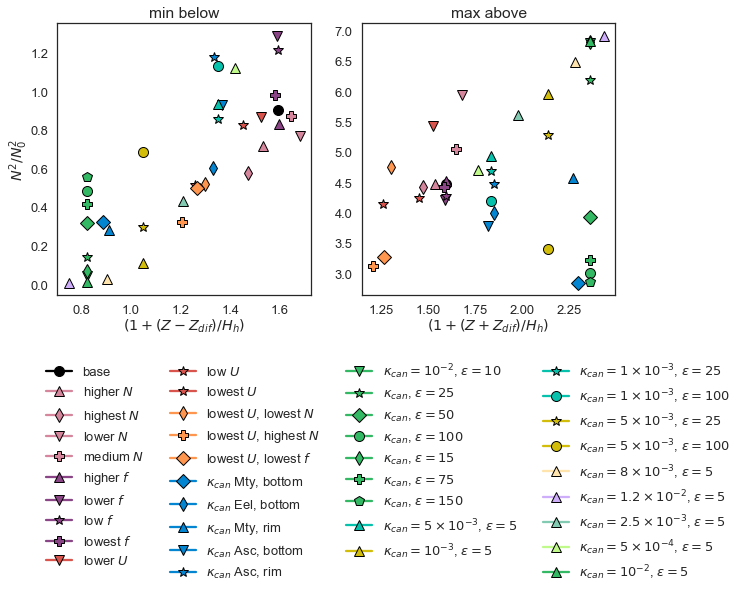

In [23]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (10,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 2)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])

t=6.5 # days

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% N/No above %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_real:
    
    Z = ((rec.f*rec.u_mod*F(Ro(rec.u_mod,rec.f,R))*L)**(0.5))/rec.N
    Zdif = np.sqrt(t*3600*24*((rec.kv-rec.kbg)))
    
     
    rec.Z = Z
    rec.Zdif = Zdif
    
    plt1 = ax0.plot((1+(Z-Zdif)/Hh),(rec.Nbe)**2/(rec.N**2),
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label)
    plt1 = ax1.plot((1+(Z+Zdif)/Hh),(rec.Nab)**2/(rec.N**2),
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label)
   

ax0.set_ylabel('$N^2/N^2_0$',labelpad=0.5)
ax0.set_xlabel(r'$(1+(Z-Z_{dif})/H_h)$',labelpad=0.5)
ax1.set_xlabel(r'$(1+(Z+Z_{dif})/H_h)$',labelpad=0.5)

ax0.set_title('min below')
ax1.set_title('max above')

Y0_array = np.array([(rec.Nbe)**2/(rec.N**2) for rec in records_step])
X0_array = np.array([1+(rec.Z-rec.Zdif)/Hh for rec in records_step])
slope0, intercept0, r_value0, p_value0, std_err0 = scipy.stats.linregress(X0_array,Y0_array)
print('For Nmin: slope = %1.2f, intercept = %1.3f, r-value = %1.3f' %(slope0, intercept0, r_value0))

Y1_array = np.array([(rec.Nab)**2/(rec.N**2) for rec in records_step])
X1_array = np.array([1+(rec.Z+rec.Zdif)/Hh for rec in records_step])
slope1, intercept1, r_value1, p_value1, std_err1 = scipy.stats.linregress(X1_array,Y1_array)
print('For Nmax: slope = %1.2f, intercept = %1.3f, r-value = %1.3f' %(slope1, intercept1, r_value1))


ax1.legend(bbox_to_anchor=(1.5,-0.2), ncol=4)

We fit a line through the step runs and dynamical runs:

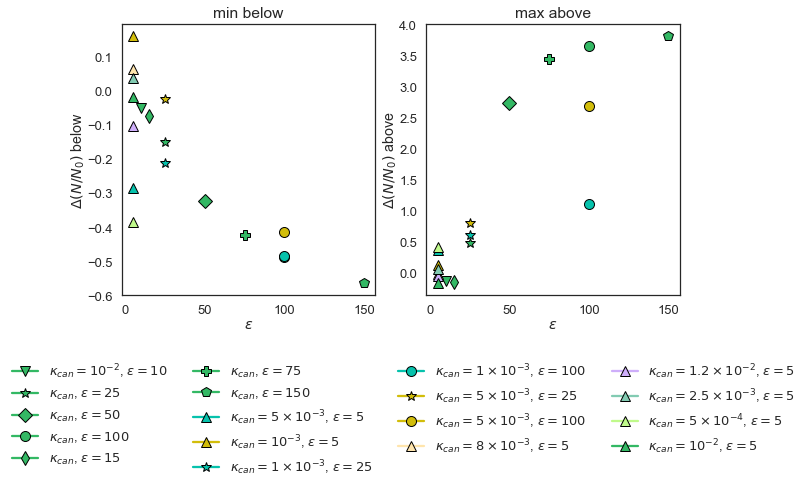

In [24]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (10,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 2)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])

t=6.5 # days

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% N/No above %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_diffusivity:

    plt1 = ax0.plot((rec.epsilon), slope0*(1+(rec.Z-rec.Zdif)/Hh)+intercept0-((rec.Nbe)**2/(rec.N**2)),
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label)
    
    plt1 = ax1.plot((rec.epsilon),slope1*(1+(rec.Z+rec.Zdif)/Hh)+intercept1-((rec.Nab)**2/(rec.N**2)),
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label)
    
    
ax0.set_xlabel('$\epsilon$',labelpad=0.5)
ax1.set_xlabel('$\epsilon$',labelpad=0.5)
ax0.set_ylabel(r'$\Delta(N/N_0)$ below',labelpad=0.5)
ax1.set_ylabel(r'$\Delta(N/N_0)$ above',labelpad=0.5)

ax1.set_title('max above')
ax0.set_title('min below')

ax1.legend(bbox_to_anchor=(1.5,-0.2), ncol=4)


In [25]:
X2_be = np.array([(rec.epsilon/(rec.kv/rec.N)**0.5)**0.5 for rec in records_diffusivity])
X1_be = np.array([1+(rec.Z-rec.Zdif)/Hh for rec in records_diffusivity])
Y_be = np.array([(rec.Nbe)**2/(rec.N**2) for rec in records_diffusivity])

X2_ab = np.array([np.log((rec.epsilon/(rec.kv/rec.N)**0.5)) for rec in records_diffusivity])
X1_ab = np.array([1+(rec.Z+rec.Zdif)/Hh for rec in records_diffusivity])
Y_ab = np.array([(rec.Nab)**2/(rec.N**2) for rec in records_diffusivity])



In [26]:
from sklearn import linear_model
reg_be = linear_model.LinearRegression()
reg_be.fit (np.transpose([X1_be,X2_be]),np.transpose(Y_be) )
print(reg_be.coef_)
print(reg_be.intercept_)

reg_ab = linear_model.LinearRegression()
reg_ab.fit (np.transpose([X1_ab, X2_ab]),np.transpose(Y_ab) )
print(reg_ab.coef_)
print(reg_ab.intercept_)


[ 1.17989602  0.04744995]
-1.02264920581
[-0.0923812  -0.94272642]
8.14685783258


In [27]:
# save values of N_eff and Phi
for rec in records_real:
    
    can_eff = rec.HCW
    Phi = np.mean(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (12,18)]))
    Phi_std = np.std(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (12,18)]))
    rec.Phi = Phi
    
    rec.Nab_scaled = np.sqrt(reg_ab.coef_[0]*(1+(rec.Z+rec.Zdif)/Hh)+
                     reg_ab.coef_[1]*np.log(rec.epsilon/(rec.kv/rec.N)**0.5)+
                     reg_ab.intercept_)*rec.N
    rec.Nbe_scaled = np.sqrt(reg_be.coef_[0]*(1+(rec.Z-rec.Zdif)/Hh)+
                     reg_be.coef_[1]*(rec.epsilon/(rec.kv/rec.N)**0.5)**0.5+
                     reg_be.intercept_)*rec.N
    
    if  (reg_be.coef_[0]*(1+(rec.Z-rec.Zdif)/Hh)+
        reg_be.coef_[1]*(rec.epsilon/(rec.kv/rec.N)**0.5)**0.5+
        reg_be.intercept_)< 0 :
        rec.N_eff_scaled = (rec.Nab_scaled)/2
    else:
        rec.N_eff_scaled =  (rec.Nab_scaled + rec.Nbe_scaled) /2
    
    

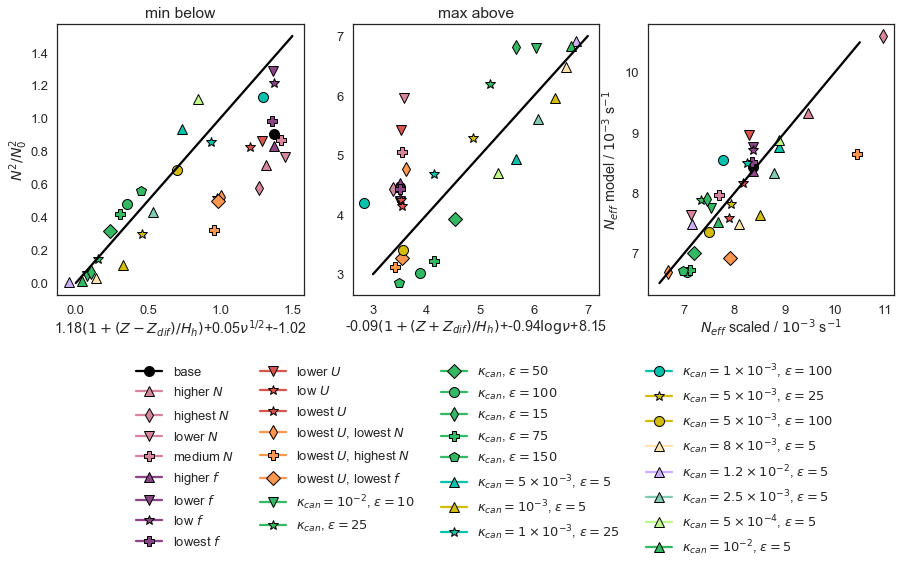

In [28]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (15,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 3)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[0,2])

t=6.5 # days

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% N/No above %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_epsilon:
    
    plt1 = ax0.plot((reg_be.coef_[0]*(1+(rec.Z-rec.Zdif)/Hh)+
                     reg_be.coef_[1]*(rec.epsilon/(rec.kv/rec.N)**0.5)**0.5+
                     reg_be.intercept_),(rec.Nbe)**2/(rec.N**2),
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label)
      
    plt1 = ax1.plot((reg_ab.coef_[0]*(1+(rec.Z+rec.Zdif)/Hh)+
                     reg_ab.coef_[1]*np.log(rec.epsilon/(rec.kv/rec.N)**0.5)+
                     reg_ab.intercept_),(rec.Nab)**2/(rec.N**2),
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label) 
    
ax0.plot(np.linspace(0,1.5,20),np.linspace(0,1.5,20), 'k-')
ax1.plot(np.linspace(3,7,20),np.linspace(3,7,20), 'k-')

ax0.set_ylabel('$N^2/N^2_0$',labelpad=0.5)
ax0.set_xlabel(r'%1.2f$(1+(Z-Z_{dif})/H_h)$+%1.2f$\nu^{1/2}$+%1.2f' %(reg_be.coef_[0], reg_be.coef_[1], reg_be.intercept_)
               ,labelpad=0.5)
ax1.set_xlabel(r'%1.2f$(1+(Z+Z_{dif})/H_h)$+%1.2f$\log{\nu}$+%1.2f' %(reg_ab.coef_[0], reg_ab.coef_[1], reg_ab.intercept_)
               ,labelpad=0.5)


ax1.set_title('max above')
ax0.set_title('min below')

for rec in records_epsilon:
    plt1 = ax2.plot(rec.N_eff_scaled/1E-3,((rec.Nbe+rec.Nab)/2)/1E-3,
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label)
ax2.plot(np.linspace(0.0065, 0.0105, 20)/1E-3,np.linspace(0.0065, 0.0105, 20)/1E-3,'k-')
ax2.set_ylabel('$N_{eff}$ model / $10^{-3}$ s$^{-1}$')
ax2.set_xlabel('$N_{eff}$ scaled / $10^{-3}$ s$^{-1}$',labelpad=0.1)
ax1.legend(bbox_to_anchor=(2,-0.2), ncol=4)


In [29]:
# records_epsilon has all runs in dyn, step and the ones where epsilon changes.

for param in np.linspace(0.8, 1.2, 30):
    for rec in records_real:

        Se = (s*rec.N)/(rec.f*((F(Ro(rec.u_mod,rec.f,W))/Ro(rec.u_mod,rec.f,L))**(1/2)))
        rec.X = (F(Ro(rec.u_mod,rec.f,W))**(3/2))*(Ro(rec.u_mod,rec.f,L)**(1/2))*((1-param*Se)**3)

        rec.Phi_nonDim = rec.Phi/(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled))
        
    Y_array = np.array([rec.Phi_nonDim for rec in records_epsilon])
    X_array = np.array([rec.X for rec in records_epsilon])

    slope2, intercept2, r_value2, p_value2, std_err2 = scipy.stats.linregress(X_array,Y_array)

    print('Using parameter %1.2f: slope = %1.2f, intercept = %1.3f, r-value = %1.3f' %(param, slope2, intercept2, r_value2))

Using parameter 0.80: slope = 4.11, intercept = -0.035, r-value = 0.932
Using parameter 0.81: slope = 4.21, intercept = -0.035, r-value = 0.937
Using parameter 0.83: slope = 4.31, intercept = -0.035, r-value = 0.941
Using parameter 0.84: slope = 4.41, intercept = -0.035, r-value = 0.944
Using parameter 0.86: slope = 4.52, intercept = -0.035, r-value = 0.948
Using parameter 0.87: slope = 4.62, intercept = -0.034, r-value = 0.951
Using parameter 0.88: slope = 4.72, intercept = -0.034, r-value = 0.953
Using parameter 0.90: slope = 4.82, intercept = -0.033, r-value = 0.956
Using parameter 0.91: slope = 4.92, intercept = -0.032, r-value = 0.958
Using parameter 0.92: slope = 5.03, intercept = -0.031, r-value = 0.960
Using parameter 0.94: slope = 5.13, intercept = -0.030, r-value = 0.961
Using parameter 0.95: slope = 5.23, intercept = -0.029, r-value = 0.963
Using parameter 0.97: slope = 5.33, intercept = -0.028, r-value = 0.964
Using parameter 0.98: slope = 5.44, intercept = -0.027, r-value 

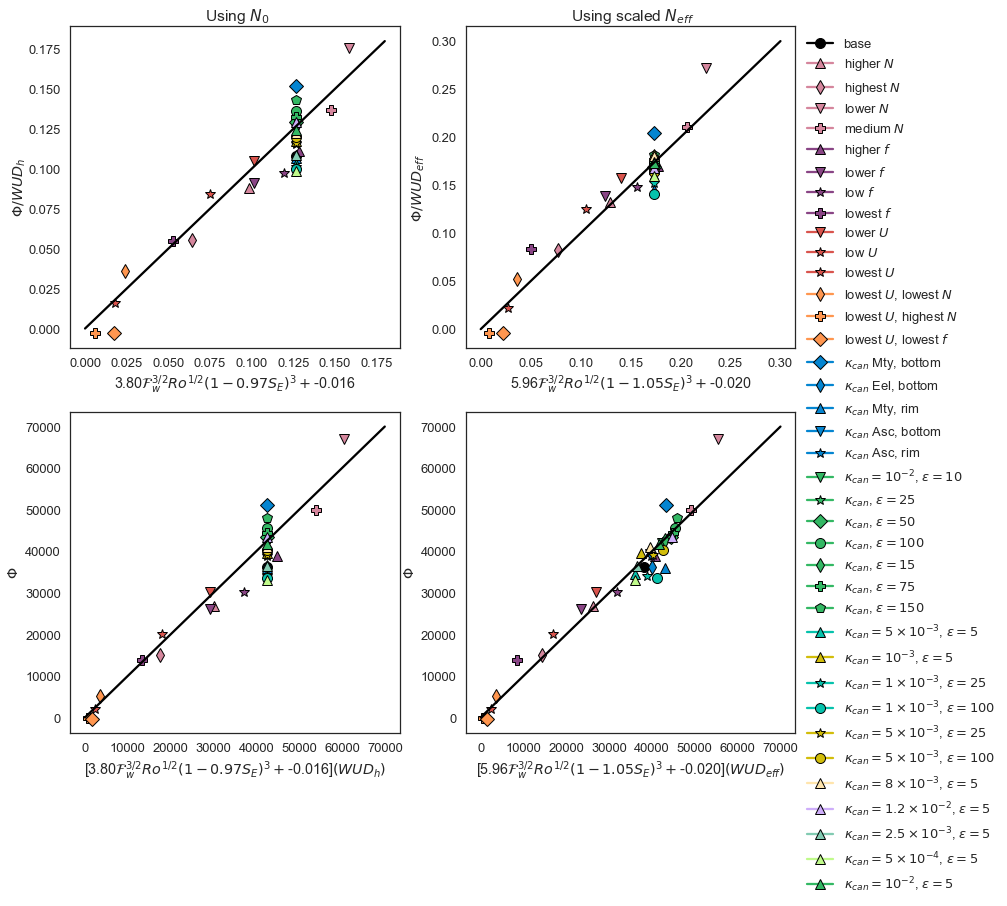

In [30]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (13,13)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(2, 2)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[1,0])
ax3 = plt.subplot(gs[1,1])

t=6.5 # days

slope = 3.80
param = 0.97
intercept = -0.016
  
slope2 = 5.96
param2 = 1.05
intercept2 = -0.020#-0.055

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% N/No above %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_real:
    
    Se = (s*rec.N)/(rec.f*((F(Ro(rec.u_mod,rec.f,W))/Ro(rec.u_mod,rec.f,L))**(1/2)))
    HA2013=((slope*(F(Ro(rec.u_mod,rec.f,W))**(3/2))*(Ro(rec.u_mod,rec.f,L)**(1/2))*((1-param*Se)**3))+intercept)
    RA2018=((slope2*(F(Ro(rec.u_mod,rec.f,W))**(3/2))*(Ro(rec.u_mod,rec.f,L)**(1/2))*((1-param2*Se)**3))+intercept2)
    
    rec.HA2013 = HA2013
    rec.RA2018 = RA2018
   
    plt1 = ax0.plot(rec.HA2013,rec.Phi/(rec.u_mod*W*Dh(rec.f,L,rec.N)),
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label)
    plt1 = ax1.plot(rec.RA2018,rec.Phi/(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled)),
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label)
    plt1 = ax2.plot(rec.HA2013*(rec.u_mod*W*Dh(rec.f,L,rec.N)),rec.Phi,
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label)
    plt1 = ax3.plot(rec.RA2018*(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled)),rec.Phi,
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label)

xx0 = np.linspace(0,0.18,50)   
ax0.plot(xx0,xx0,'k-')
ax1.plot(np.linspace(0,0.3,50),np.linspace(0,0.3,50),'k-')

xx1 = np.linspace(0,70000,50)   
ax2.plot(xx1,xx1,'k-')
ax3.plot(xx1,xx1,'k-')

ax0.set_ylabel('Phi',labelpad=0.5)
ax0.set_ylabel('$\Phi/WUD_h$')
ax1.set_ylabel('$\Phi/WUD_{eff}$')
ax2.set_ylabel('$\Phi$')
ax3.set_ylabel('$\Phi$')

ax0.set_xlabel(r'%1.2f$\mathcal{F}_w^{3/2}Ro^{1/2}(1-%1.2f S_E)^3+$%1.3f' %(slope,param, intercept))
ax1.set_xlabel(r'%1.2f$\mathcal{F}_w^{3/2}Ro^{1/2}(1-%1.2f S_E)^3+$%1.3f' %(slope2,param2, intercept2))
ax2.set_xlabel(r'[%1.2f$\mathcal{F}_w^{3/2}Ro^{1/2}(1-%1.2f S_E)^3+$%1.3f]$(WUD_h)$' %(slope,param, intercept))
ax3.set_xlabel(r'[%1.2f$\mathcal{F}_w^{3/2}Ro^{1/2}(1-%1.2f S_E)^3+$%1.3f]$(WUD_{eff})$' %(slope2,param2, intercept2))

ax0.set_title(' Using $N_0$')
ax1.set_title(' Using scaled $N_{eff}$')

ax1.legend(bbox_to_anchor=(1,1), ncol=1)


## Tracer gradient, concentration and upwelling tracer flux

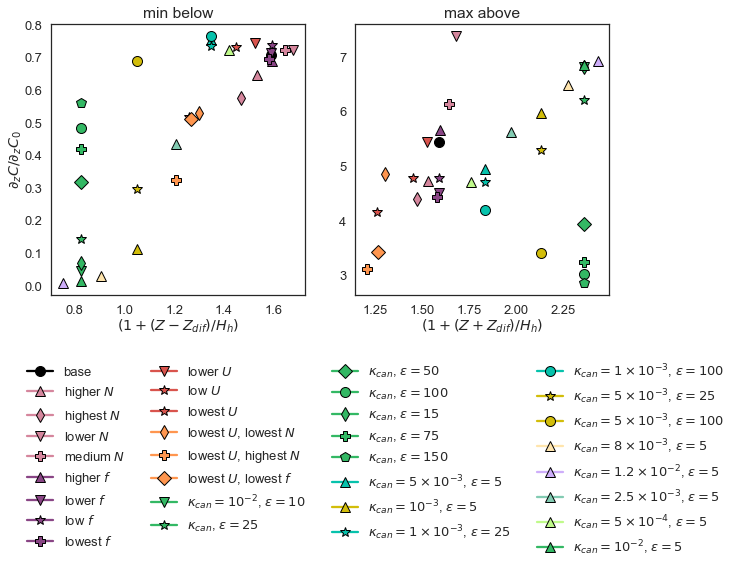

In [31]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (10,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 2)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])

t=6.5 # days

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% tracer gradient %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_epsilon:
    
    plt1 = ax0.plot((1+(rec.Z-rec.Zdif)/Hh),(rec.dTr_be)/(rec.dTr0),
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label)
    plt1 = ax1.plot((1+(rec.Z+rec.Zdif)/Hh),(rec.dTr_ab)/(rec.dTr0),
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label)
   

ax0.set_ylabel('$\partial_zC/\partial_zC_0$',labelpad=0.5)
ax0.set_xlabel(r'$(1+(Z-Z_{dif})/H_h)$',labelpad=0.5)
ax1.set_xlabel(r'$(1+(Z+Z_{dif})/H_h)$',labelpad=0.5)

ax0.set_title('min below')
ax1.set_title('max above')


ax1.legend(bbox_to_anchor=(1.5,-0.2), ncol=4)

In [32]:
X2_be = np.array([(rec.epsilon/(rec.kv/rec.N)**0.5)**0.5 for rec in records_diffusivity])
X1_be = np.array([1+(rec.Z-rec.Zdif)/Hh for rec in records_diffusivity])
Y_be = np.array([(rec.dTr_be)/(rec.dTr0) for rec in records_diffusivity])

X2_ab = np.array([np.log((rec.epsilon/(rec.kv/rec.N)**0.5)) for rec in records_diffusivity])
X1_ab = np.array([1+(rec.Z+rec.Zdif)/Hh for rec in records_diffusivity])
Y_ab = np.array([(rec.dTr_ab)/(rec.dTr0) for rec in records_diffusivity])


In [33]:
from sklearn import linear_model
reg_be_dTr = linear_model.LinearRegression()
reg_be_dTr.fit (np.transpose([X1_be,X2_be]),np.transpose(Y_be) )
print(reg_be_dTr.coef_)
print(reg_be_dTr.intercept_)

reg_ab_dTr = linear_model.LinearRegression()
reg_ab_dTr.fit (np.transpose([X1_ab, X2_ab]),np.transpose(Y_ab) )
print(reg_ab_dTr.coef_)
print(reg_ab_dTr.intercept_)


[ 0.76815785  0.04134189]
-0.634276105116
[-0.10450298 -0.94488711]
8.18892460181


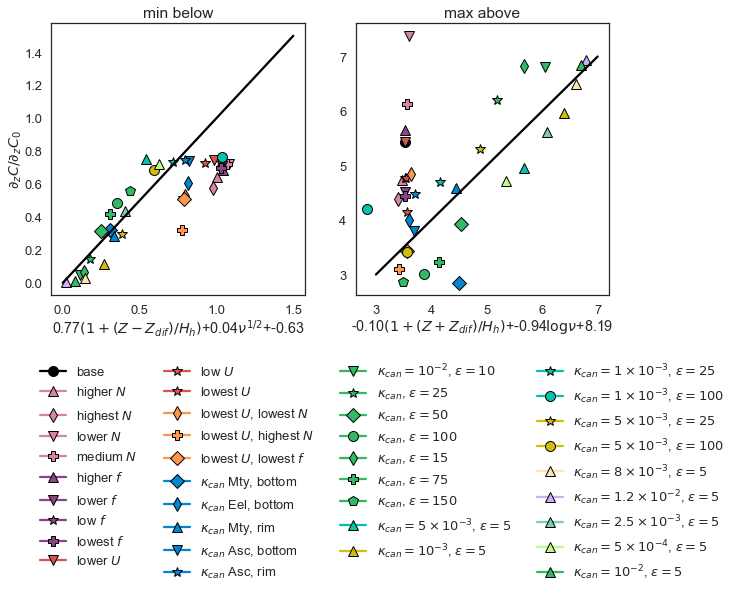

In [34]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (10,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 2)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])

t=6.5 # days

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Tracer gradient %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_real:
    
    plt1 = ax0.plot((reg_be_dTr.coef_[0]*(1+(rec.Z-rec.Zdif)/Hh)+
                     reg_be_dTr.coef_[1]*(rec.epsilon/(rec.kv/rec.N)**0.5)**0.5+
                     reg_be_dTr.intercept_),(rec.dTr_be)/(rec.dTr0),
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label)
    rec.X1_be = (rec.epsilon/(rec.kv/rec.N)**0.5)**0.5
    rec.X2_be = 1+(rec.Z-rec.Zdif)/Hh
    
    plt1 = ax1.plot((reg_ab_dTr.coef_[0]*(1+(rec.Z+rec.Zdif)/Hh)+
                     reg_ab_dTr.coef_[1]*np.log(rec.epsilon/(rec.kv/rec.N)**0.5)+
                     reg_ab_dTr.intercept_),(rec.dTr_ab)/(rec.dTr0),
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label)
    rec.X1_ab = np.log((rec.epsilon/(rec.kv/rec.N)**0.5))
    rec.X2_ab = 1+(rec.Z+rec.Zdif)/Hh
    
ax0.plot(np.linspace(0,1.5,20),np.linspace(0,1.5,20), 'k-')
ax1.plot(np.linspace(3,7,20),np.linspace(3,7,20), 'k-')

ax0.set_ylabel('$\partial_zC/\partial_zC_0$',labelpad=0.5)
ax0.set_xlabel(r'%1.2f$(1+(Z-Z_{dif})/H_h)$+%1.2f$\nu^{1/2}$+%1.2f' %(reg_be_dTr.coef_[0], reg_be_dTr.coef_[1], reg_be_dTr.intercept_)
               ,labelpad=0.5)
ax1.set_xlabel(r'%1.2f$(1+(Z+Z_{dif})/H_h)$+%1.2f$\log{\nu}$+%1.2f' %(reg_ab_dTr.coef_[0], reg_ab_dTr.coef_[1], reg_ab_dTr.intercept_)
               ,labelpad=0.5)


ax1.set_title('max above')
ax0.set_title('min below')


ax1.legend(bbox_to_anchor=(1.5,-0.2), ncol=4)


In [35]:
# save values of dTr scaled
for rec in records_real:
    
    can_eff = rec.TrMass
    Phi_Tr = np.mean(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (12,18)]))
    rec.PhiTr = Phi_Tr
    
    rec.dTr_ab_scaled = (reg_ab_dTr.coef_[0]*(1+(rec.Z+rec.Zdif)/Hh)+
                        reg_ab_dTr.coef_[1]*np.log(rec.epsilon/(rec.kv/rec.N)**0.5)+
                        reg_ab_dTr.intercept_)*rec.dTr0
    rec.dTr_be_scaled = (reg_be_dTr.coef_[0]*(1+(rec.Z-rec.Zdif)/Hh)+
                        reg_be_dTr.coef_[1]*(rec.epsilon/(rec.kv/rec.N)**0.5)**0.5+
                        reg_be_dTr.intercept_)*rec.dTr0
    
    if  (reg_be_dTr.coef_[0]*(1+(rec.Z-rec.Zdif)/Hh)+
        reg_be_dTr.coef_[1]*(rec.epsilon/(rec.kv/rec.N)**0.5)**0.5+
        reg_be_dTr.intercept_)< 0 :
        rec.dTr_eff_scaled = (rec.dTr_ab_scaled)/2
    else:
        rec.dTr_eff_scaled =  (rec.dTr_ab_scaled + rec.dTr_be_scaled) /2

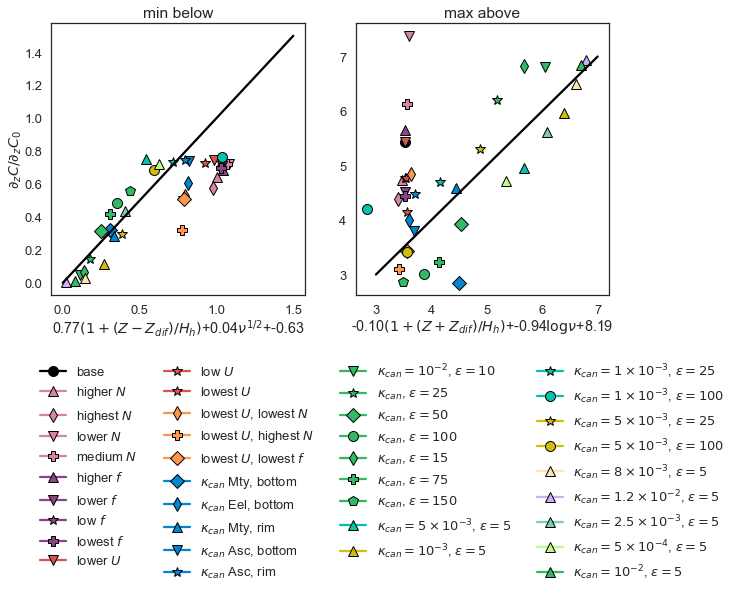

In [36]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (10,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 2)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])

t=6.5 # days

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Concentration at rim %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_real:
    
    plt1 = ax0.plot((reg_be_dTr.coef_[0]*(1+(rec.Z-rec.Zdif)/Hh)+
                     reg_be_dTr.coef_[1]*(rec.epsilon/(rec.kv/rec.N)**0.5)**0.5+
                     reg_be_dTr.intercept_),(rec.dTr_be)/(rec.dTr0),
                     marker = rec.mstyle,
                     markersize = 10,
                     color = sns.xkcd_rgb[rec.color2],
                     markeredgewidth=1.0,
                     markeredgecolor = 'k',
                     label=rec.label)
   
    plt1 = ax1.plot((reg_ab_dTr.coef_[0]*(1+(rec.Z+rec.Zdif)/Hh)+
                     reg_ab_dTr.coef_[1]*np.log(rec.epsilon/(rec.kv/rec.N)**0.5)+
                     reg_ab_dTr.intercept_),(rec.dTr_ab)/(rec.dTr0),
                     marker = rec.mstyle,
                     markersize = 10,
                     color = sns.xkcd_rgb[rec.color2],
                     markeredgewidth=1.0,
                     markeredgecolor = 'k',
                     label=rec.label)
    
ax0.plot(np.linspace(0,1.5,20),np.linspace(0,1.5,20), 'k-')
ax1.plot(np.linspace(3,7,20),np.linspace(3,7,20), 'k-')

ax0.set_ylabel('$\partial_zC/\partial_zC_0$',labelpad=0.5)
ax0.set_xlabel(r'%1.2f$(1+(Z-Z_{dif})/H_h)$+%1.2f$\nu^{1/2}$+%1.2f' %(reg_be_dTr.coef_[0], reg_be_dTr.coef_[1], reg_be_dTr.intercept_)
               ,labelpad=0.5)
ax1.set_xlabel(r'%1.2f$(1+(Z+Z_{dif})/H_h)$+%1.2f$\log{\nu}$+%1.2f' %(reg_ab_dTr.coef_[0], reg_ab_dTr.coef_[1], reg_ab_dTr.intercept_)
               ,labelpad=0.5)


ax1.set_title('max above')
ax0.set_title('min below')


ax1.legend(bbox_to_anchor=(1.5,-0.2), ncol=4)

### Concentration

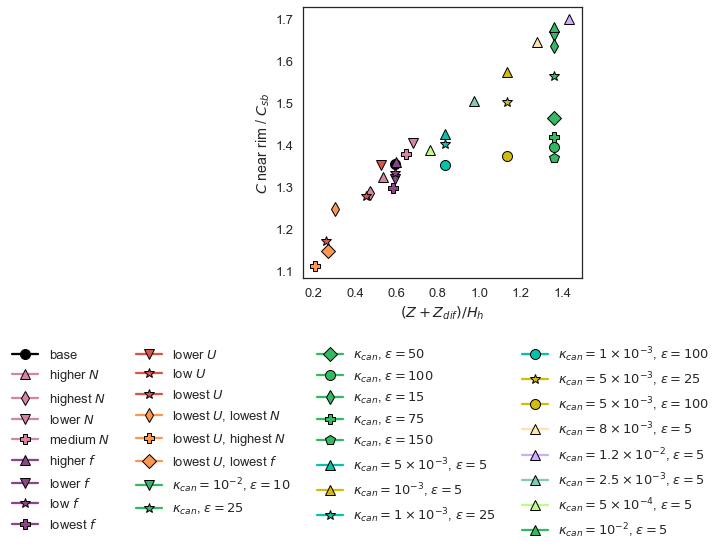

In [37]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (5,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0])

t=6.5 # days

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Concentration at rim %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_epsilon:
    plt1 = ax0.plot(((rec.Z+rec.Zdif)/Hh),rec.Tr/rec.Tr0,
                     marker = rec.mstyle,
                     markersize = 10,
                     color = sns.xkcd_rgb[rec.color2],
                     markeredgewidth=1.0,
                     markeredgecolor = 'k',
                     label=rec.label)
ax0.set_ylabel('$C$ near rim / $C_{sb}$')
ax0.set_xlabel(r'$(Z+Z_{dif})/H_h$')


ax0.legend(bbox_to_anchor=(1.5,-0.2), ncol=4)


In [38]:
X_simple = np.array([(rec.Z+rec.Zdif)/Hh for rec in records_step])
Y_C = np.array([rec.Tr/rec.Tr0 for rec in records_step])

reg_Csimple = linear_model.LinearRegression()
reg_Csimple.fit (np.transpose([X_simple]),np.transpose(Y_C) )
print(reg_Csimple.coef_)
print(reg_Csimple.intercept_)



[ 0.45029028]
1.06896220927


Text(0,0.5,'$C$ near rim / $C_{sb}$')

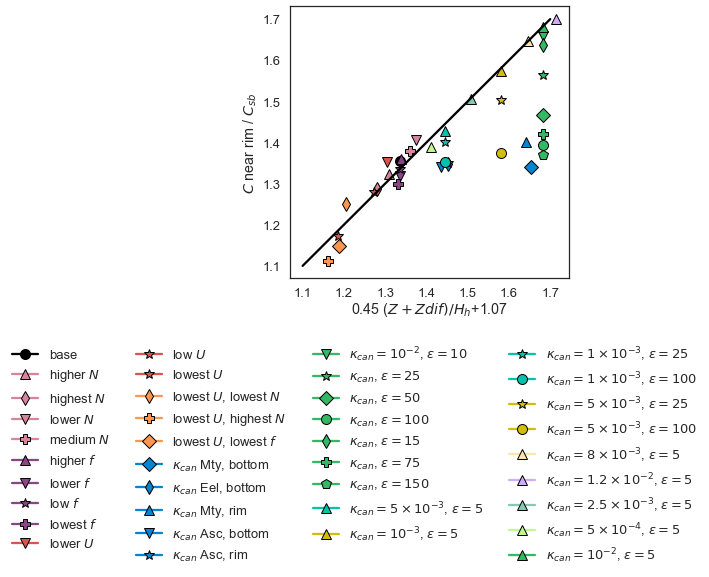

In [39]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (5,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0])

t=6.5 # days

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Concentration at rim %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_real:
  
    plt1 = ax0.plot((reg_Csimple.coef_*((rec.Z+rec.Zdif)/Hh)+  
                    reg_Csimple.intercept_),
                    (rec.Tr/rec.Tr0),
                     marker = rec.mstyle,
                     markersize = 10,
                     color = sns.xkcd_rgb[rec.color2],
                     markeredgewidth=1.0,
                     markeredgecolor = 'k',
                     label=rec.label)
    rec.Tr_scaled_simple = (reg_Csimple.coef_*((rec.Z+rec.Zdif)/Hh)+  
                           reg_Csimple.intercept_)*rec.Tr0
ax0.plot(np.linspace(1.1,1.7,20),np.linspace(1.1,1.7,20),'k-')       
ax0.legend(bbox_to_anchor=(1.5,-0.2), ncol=4)

ax0.set_xlabel(r'%1.2f ($Z+Zdif)/H_h$+%1.2f' %(reg_Csimple.coef_,reg_Csimple.intercept_),labelpad=0.5)
ax0.set_ylabel(r'$C$ near rim / $C_{sb}$')

Text(0,0.5,'C scaled - C model')

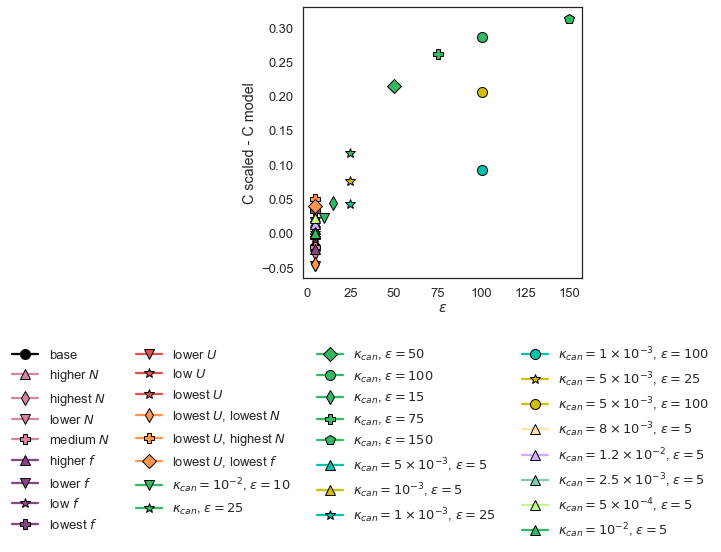

In [40]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (5,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0])

t=6.5 # days

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Concentration at rim %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_epsilon:
  
    plt1 = ax0.plot(rec.epsilon,(reg_Csimple.coef_*((rec.Z+rec.Zdif)/Hh)+  
                    reg_Csimple.intercept_)-(rec.Tr/rec.Tr0),
                     marker = rec.mstyle,
                     markersize = 10,
                     color = sns.xkcd_rgb[rec.color2],
                     markeredgewidth=1.0,
                     markeredgecolor = 'k',
                     label=rec.label)
    
ax0.legend(bbox_to_anchor=(1.5,-0.2), ncol=4)

ax0.set_xlabel(r'$\epsilon$' ,labelpad=0.5)
ax0.set_ylabel(r'C scaled - C model')

In [41]:
X1_C = np.array([(rec.Z+rec.Zdif)/Hh for rec in records_epsilon])
X2_C = np.array([(rec.epsilon/(rec.kv/rec.N)**0.5)**0.5 for rec in records_epsilon])
Y_C = np.array([rec.Tr/rec.Tr0 for rec in records_epsilon])

reg_C = linear_model.LinearRegression()
reg_C.fit (np.transpose([X1_C,X2_C]),np.transpose(Y_C) )
print(reg_C.coef_)
print(reg_C.intercept_)

[ 0.19127809 -0.01902964]
1.39386987797


Text(0,0.5,'$C$ at rim depth / $C_{0}$')

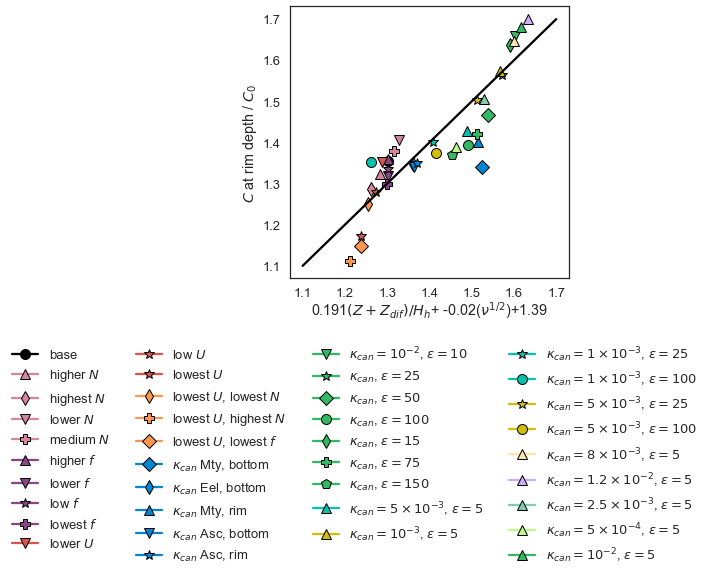

In [42]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (5,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0])

t=6.5 # days

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Concentration at rim %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_real:
  
    plt1 = ax0.plot((reg_C.coef_[0]*((rec.Z+rec.Zdif)/Hh)+
                    reg_C.coef_[1]*((rec.epsilon/(rec.kv/rec.N)**0.5)**0.5)+  
                    reg_C.intercept_),
                    (rec.Tr/rec.Tr0),
                     marker = rec.mstyle,
                     markersize = 10,
                     color = sns.xkcd_rgb[rec.color2],
                     markeredgewidth=1.0,
                     markeredgecolor = 'k',
                     label=rec.label)
    rec.Tr_scaled = (reg_C.coef_[0]*((rec.Z+rec.Zdif)/Hh)+
                    reg_C.coef_[1]*((rec.epsilon/(rec.kv/rec.N)**0.5)**0.5)+  
                    reg_C.intercept_)*rec.Tr0
ax0.plot(np.linspace(1.1,1.7,20),np.linspace(1.1,1.7,20),'k-')       
ax0.legend(bbox_to_anchor=(1.5,-0.2), ncol=4)

ax0.set_xlabel(r'%1.3f$(Z+Z_{dif})/H_h$+ %1.2f($\nu^{1/2}$)+%1.2f' %(reg_C.coef_[0],reg_C.coef_[1],reg_C.intercept_),labelpad=0.5)
ax0.set_ylabel(r'$C$ at rim depth / $C_{0}$')

Text(0.5,1,' $\\Phi_{Tr}$')

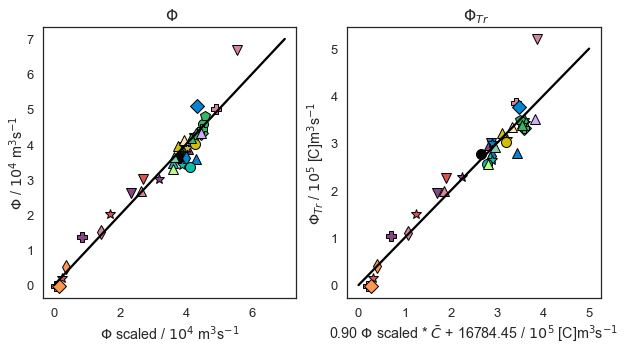

In [43]:
plt.rcParams['font.size'] = 8.0

fig,(ax0, ax1) = plt.subplots(1, 2, figsize=(10,5))
t=6.5 # days

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% N/No above %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_real:
    
    Y_array = np.array([rec.PhiTr for rec in records_epsilon])
    X_array = np.array([rec.RA2018*(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled))*(rec.Tr_scaled) for rec in records_epsilon])

    slope6, intercept6, r_value6, p_value6, std_err6 = scipy.stats.linregress(np.squeeze(X_array),Y_array)

   
    plt1 = ax0.plot(rec.RA2018*(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled))/1E4,rec.Phi/1E4,
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label)
    plt1 = ax1.plot((slope6*(rec.RA2018*(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled))*(rec.Tr_scaled))+intercept6)/1E5,
                    rec.PhiTr/1E5,
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label)

ax0.plot(np.linspace(0,7,50),np.linspace(0,7,50),'k-')
ax1.plot(np.linspace(0,5,50),np.linspace(0,5,50),'k-')


ax0.set_ylabel('Phi',labelpad=0.5)
ax0.set_ylabel('$\Phi$ / $10^4$ m$^3$s$^{-1}$')
ax1.set_ylabel('$\Phi_{Tr}$ / $10^5$ [C]m$^3$s$^{-1}$')

ax0.set_xlabel(r'$\Phi$ scaled / $10^4$ m$^3$s$^{-1}$' )
ax1.set_xlabel(r'%1.2f $\Phi$ scaled * $\bar{C}$ + %1.2f / $10^5$ [C]m$^3$s$^{-1}$' %(slope6, intercept6))

ax0.set_title(' $\Phi$')
ax1.set_title(' $\Phi_{Tr}$')



## Paper Figures

### Figure 9

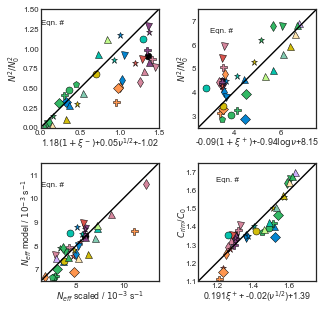

In [61]:
sns.set_context('paper')
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (5,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(2, 2, hspace=0.3, wspace=0.3)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[1,0])
ax3 = plt.subplot(gs[1,1])

t=6.5 # days

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% N/No above %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_real:
    
    plt0 = ax0.plot((rec.Nbe_scaled/rec.N)**2,(rec.Nbe)**2/(rec.N**2),
                    marker = rec.mstyle,
                    markersize = 7,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=0.5,
                    markeredgecolor = 'k',
                    label=rec.label)
      
    plt1 = ax1.plot((rec.Nab_scaled/rec.N)**2,(rec.Nab)**2/(rec.N**2),
                    marker = rec.mstyle,
                    markersize = 7,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=0.5,
                    markeredgecolor = 'k',
                    label=rec.label) 
    
    plt2 = ax2.plot(rec.N_eff_scaled/1E-3,((rec.Nbe+rec.Nab)/2)/1E-3,
                    marker = rec.mstyle,
                    markersize = 7,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=0.5,
                    markeredgecolor = 'k',
                    label=rec.label)
    plt3 = ax3.plot(rec.Tr_scaled/rec.Tr0,
                    (rec.Tr/rec.Tr0),
                     marker = rec.mstyle,
                     markersize = 7,
                     color = sns.xkcd_rgb[rec.color2],
                     markeredgewidth=0.5,
                     markeredgecolor = 'k',
                     label=rec.label)
    
ax0.plot(np.linspace(0,1.5,20),np.linspace(0,1.5,20), 'k-')
ax1.plot(np.linspace(2.5,7.5,20),np.linspace(2.5,7.5,20), 'k-')
ax2.plot(np.linspace(0.0065, 0.0115, 20)/1E-3,np.linspace(0.0065, 0.0115, 20)/1E-3,'k-')
ax3.plot(np.linspace(1, 1.8, 20),np.linspace(1, 1.8, 20),'k-')

ax0.set_xlim(0,1.5)
ax0.set_ylim(0,1.5)

ax1.set_xlim(2.5,7.5)
ax1.set_ylim(2.5,7.5)

ax2.set_xlim(6.5,11.5)
ax2.set_ylim(6.5,11.5)

ax3.set_xlim(1.1,1.75)
ax3.set_ylim(1.1,1.75)


ax0.set_ylabel('$N^2/N^2_0$',labelpad=0.5)
ax1.set_ylabel('$N^2/N^2_0$',labelpad=0.5)

ax0.set_xlabel(r'%1.2f$(1+\xi^-)$+%1.2f$\nu^{1/2}$+%1.2f' %(reg_be.coef_[0], reg_be.coef_[1], reg_be.intercept_)
               ,labelpad=0.5)
ax1.set_xlabel(r'%1.2f$(1+\xi^+)$+%1.2f$\log{\nu}$+%1.2f' %(reg_ab.coef_[0], reg_ab.coef_[1], reg_ab.intercept_)
               ,labelpad=0.5)


ax1.text(3,6.5,'Eqn. #')
ax0.text(0,1.3,'Eqn. #')
ax2.text(6.5,10.5,'Eqn. #')
ax3.text(1.2,1.65,'Eqn. #')

ax2.set_ylabel('$N_{eff}$ model / $10^{-3}$ s$^{-1}$', labelpad=-4)
ax2.set_xlabel('$N_{eff}$ scaled / $10^{-3}$ s$^{-1}$',labelpad=0.0)

ax3.set_ylabel('$C_{rim}$/$C_0$', labelpad=-4)
ax3.set_xlabel(r'%1.3f$\xi^+$+ %1.2f($\nu^{1/2}$)+%1.2f' %(reg_C.coef_[0],reg_C.coef_[1],reg_C.intercept_),labelpad=0.0)

#ax1.legend(bbox_to_anchor=(1,1), ncol=2,columnspacing=0.1,frameon=True )

ax0.tick_params(axis='x', pad=2)
ax1.tick_params(axis='x', pad=2)
ax2.tick_params(axis='x', pad=2)
ax3.tick_params(axis='x', pad=2)

ax0.tick_params(axis='y', pad=2)
ax1.tick_params(axis='y', pad=2)
ax2.tick_params(axis='y', pad=2)
ax3.tick_params(axis='y', pad=2)

ax0.set_aspect(1)
ax1.set_aspect(1)
ax2.set_aspect(1)
ax3.set_aspect(1)

plt.savefig('figure9_v2.eps',format='eps',bbox_inches='tight')


### Figure 10

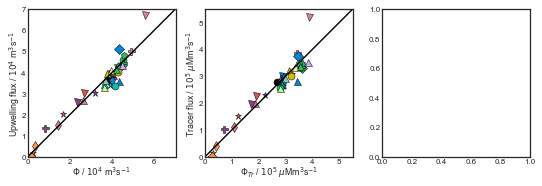

In [48]:
sns.set_context('paper')
plt.rcParams['font.size'] = 10.0
f = plt.figure(figsize = (9,3)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 3)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[0,2])

t=6.5 # days

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% N/No above %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_real:
    
    plt1 = ax0.plot(rec.RA2018*(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled))/1E4,rec.Phi/1E4,
                    marker = rec.mstyle,
                    markersize = 7,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=0.5,
                    markeredgecolor = 'k',
                    label=rec.label)
    plt1 = ax1.plot((slope6*(rec.RA2018*(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled))*(rec.Tr_scaled))+intercept6)/1E5,
                    rec.PhiTr/1E5,
                    marker = rec.mstyle,
                    markersize = 7,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=0.5,
                    markeredgecolor = 'k',
                    label=rec.label)

ax0.plot(np.linspace(0,7,50),np.linspace(0,7,50),'k-')
ax1.plot(np.linspace(0,5.5,50),np.linspace(0,5.5,50),'k-')


ax0.set_ylabel('Phi',labelpad=0.5)
ax0.set_ylabel('Upwelling flux / $10^4$ m$^3$s$^{-1}$', labelpad=-0.5)
ax1.set_ylabel('Tracer flux / $10^5$ $\mu$Mm$^3$s$^{-1}$', labelpad=-0.5)

ax0.set_xlabel(r'$\Phi$ / $10^4$ m$^3$s$^{-1}$', labelpad=-0.5 )
ax1.set_xlabel(r'$\Phi_{Tr}$ / $10^5$ $\mu$Mm$^3$s$^{-1}$', labelpad=-0.5)

ax0.set_xlim(0,7)
ax0.set_ylim(0,7)

ax1.set_xlim(0,5.5)
ax1.set_ylim(0,5.5)

#ax1.text(3,6.5,'Eqn. #')
#ax0.text(0,1.3,'Eqn. #')
#ax2.text(6.5,10.5,'Eqn. #')


#ax2.legend(bbox_to_anchor=(1,-0.2), ncol=3,columnspacing=0.1)

ax0.tick_params(axis='x', pad=2)
ax1.tick_params(axis='x', pad=2)
ax2.tick_params(axis='x', pad=2)

ax0.tick_params(axis='y', pad=2)
ax1.tick_params(axis='y', pad=2)
ax2.tick_params(axis='y', pad=2)

ax0.set_aspect(1)
ax1.set_aspect(1)
ax2.set_aspect(1)

plt.savefig('figure10_v2.eps',format='eps',bbox_inches='tight')
